### Human in the Loop Middleware

Pause agent execution for human approval, editing or rejection of tool calls before they execute.
Human-in-the-loop is useful for the following:
* High-stakes opeartions requriing human approval (e.g. database writes, financial transactions)
* Compliance workflows where human oversight is mandatory.
* Long-running conversations where human feedback guides the agents.

A human decision then determines what happens next: the action can be approved as-is (approve), modified before running (edit), or rejected with feedback (reject).

In [1]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_groq import ChatGroq
from langchain.tools import tool

@tool
def read_email_tool(email_id:str)->str:
    "a function to read an email by it's id"
    return f"Email content for ID: {email_id}"

@tool
def send_email_tool(recipient:str, subject:str)->str:
    "a function to send an email"
    return f"Email sent to {recipient}, with subject: {subject}"

d:\RAGs In Depth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


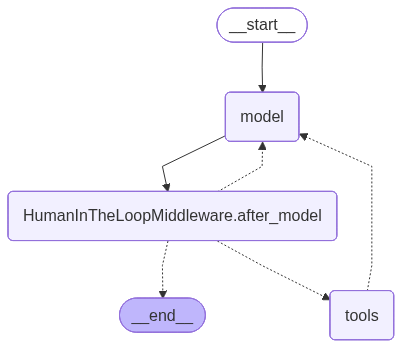

In [2]:
agent = create_agent(
    model=ChatGroq(model="llama-3.1-8b-instant"),
    tools=[read_email_tool, send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool":{"allowed_decisions":['approve', 'edit', 'reject']},
                "read_email_tool":False #if it is True, All decisions (approve, edit, reject) allowed
                          }
        )
    ]
)

agent

In [3]:
config = {"configurable": {"thread_id":"test_approver"}}

response = agent.invoke({"messages":[{"role":"user", "content":"send email to mounica@gmail.com with subject : 'Testing HITL Middleware'"}]}, config=config)
response

{'messages': [HumanMessage(content="send email to mounica@gmail.com with subject : 'Testing HITL Middleware'", additional_kwargs={}, response_metadata={}, id='d7026a26-1549-45c4-83ca-a6b8089e1edd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q8p47zd7s', 'function': {'arguments': '{"recipient":"mounica@gmail.com","subject":"Testing HITL Middleware"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 302, 'total_tokens': 331, 'completion_time': 0.03637704, 'completion_tokens_details': None, 'prompt_time': 0.017221842, 'prompt_tokens_details': None, 'queue_time': 0.050419778, 'total_time': 0.053598882}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b47d3-ddda-7fc0-ad18-55e0437e76d2-0', tool_calls=[{'name': 'send_email_tool', 'args': {'recip

#### Responding to interrupts

When you invoke the agent, it runs until it either completes or an interrupt is raised. An interrupt is triggered when a tool call matches the policy you configured in interrupt_on. In that case, the invocation result will include an __interrupt__ field with the actions that require review. You can then present those actions to a reviewer and resume execution once decisions are provided.

In [4]:
response['__interrupt__']

[Interrupt(value={'action_requests': [{'name': 'send_email_tool', 'args': {'recipient': 'mounica@gmail.com', 'subject': 'Testing HITL Middleware'}, 'description': "Tool execution requires approval\n\nTool: send_email_tool\nArgs: {'recipient': 'mounica@gmail.com', 'subject': 'Testing HITL Middleware'}"}], 'review_configs': [{'action_name': 'send_email_tool', 'allowed_decisions': ['approve', 'edit', 'reject']}]}, id='45b384f368b5ab9ad1a24d6f353c2872')]

####  To resume with approval decision

In [5]:
from langgraph.types import Command
if "__interrupt__" in response:
    print("Paused ..Approving Now")
    
    approved = agent.invoke(
        Command(resume={"decisions": [{"type": "approve"}]}),
        config=config
    )

approved['messages'][-1].content    

Paused ..Approving Now


"However, since the recipient's email is not valid, the email will not be sent."

#### To resume with reject decision

In [6]:
config = {"configurable":{"thread_id":"test_rejector"}}

to_reject = agent.invoke({"messages":{"role": "user", "content": "Send email to sam@gmail.com with subject as 'Rejection Decision' "}}, config=config)
to_reject

{'messages': [HumanMessage(content="Send email to sam@gmail.com with subject as 'Rejection Decision' ", additional_kwargs={}, response_metadata={}, id='c33f865c-3617-4268-8f8f-665f0fd1966d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'e3acq6r9d', 'function': {'arguments': '{"recipient":"sam@gmail.com","subject":"Rejection Decision"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 300, 'total_tokens': 326, 'completion_time': 0.031144589, 'completion_tokens_details': None, 'prompt_time': 0.016560101, 'prompt_tokens_details': None, 'queue_time': 0.049866889, 'total_time': 0.04770469}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b47d3-e009-76a0-bc73-07021a499b69-0', tool_calls=[{'name': 'send_email_tool', 'args': {'recipient': 'sam@gmai

In [7]:
if "__interrupt__" in to_reject:
    print("Rejecting action with feedback")

    reject_result = agent.invoke(
        Command(resume={"decisions": [{"type": "reject", "message": "Wrong subject selected"}]}),
        config=config
    )

reject_result

Rejecting action with feedback


{'messages': [HumanMessage(content="Send email to sam@gmail.com with subject as 'Rejection Decision' ", additional_kwargs={}, response_metadata={}, id='c33f865c-3617-4268-8f8f-665f0fd1966d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'e3acq6r9d', 'function': {'arguments': '{"recipient":"sam@gmail.com","subject":"Rejection Decision"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 300, 'total_tokens': 326, 'completion_time': 0.031144589, 'completion_tokens_details': None, 'prompt_time': 0.016560101, 'prompt_tokens_details': None, 'queue_time': 0.049866889, 'total_time': 0.04770469}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b47d3-e009-76a0-bc73-07021a499b69-0', tool_calls=[{'name': 'send_email_tool', 'args': {'recipient': 'sam@gmai

#### To resume with editing

In [14]:
config= {"configurable": {"thread_id":"test_edit"}}

edit_response = agent.invoke({"messages":[{"role":"user", "content":"Send email to aryan@gmail.com with subject 'You can do better!!'"}]},
                             config=config)

edit_response

{'messages': [HumanMessage(content="Send email to aryan@gmail.com with subject 'You can do better!!'", additional_kwargs={}, response_metadata={}, id='a3d367e6-2f0d-4de2-a781-98949ef955de'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xn7hwc4dd', 'function': {'arguments': '{"recipient":"aryan@gmail.com","subject":"You can do better!!"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 301, 'total_tokens': 329, 'completion_time': 0.034716154, 'completion_tokens_details': None, 'prompt_time': 0.018543101, 'prompt_tokens_details': None, 'queue_time': 0.051185509, 'total_time': 0.053259255}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b47d7-e3a4-7ee2-8465-522376083897-0', tool_calls=[{'name': 'send_email_tool', 'args': {'recipient': 'aryan

In [15]:
if '__interrupt__' in edit_response:
    result = agent.invoke(
        Command(resume={
            "decisions":
            [{"type":"edit",
              "edited_action": {
                  "name": "send_email_tool",
                  "args":{"recipient": "sammy@gmail.com", "subject": "Keep Going!!"}}
        }]
        } ),
        config=config
    )

result    

{'messages': [HumanMessage(content="Send email to aryan@gmail.com with subject 'You can do better!!'", additional_kwargs={}, response_metadata={}, id='a3d367e6-2f0d-4de2-a781-98949ef955de'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xn7hwc4dd', 'function': {'arguments': '{"recipient":"aryan@gmail.com","subject":"You can do better!!"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 301, 'total_tokens': 329, 'completion_time': 0.034716154, 'completion_tokens_details': None, 'prompt_time': 0.018543101, 'prompt_tokens_details': None, 'queue_time': 0.051185509, 'total_time': 0.053259255}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b47d7-e3a4-7ee2-8465-522376083897-0', tool_calls=[{'type': 'tool_call', 'name': 'send_email_tool', 'args':